In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import pickle
import joblib
from sklearn.linear_model import LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from scipy.optimize import minimize

DATA_PATH_IMDB = 'data/desafio_indicium_imdb.csv'

In [2]:
data_imdb = pd.read_csv(DATA_PATH_IMDB) 

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">TRATAMENTO DO TIPO DE DADOS DAS COLUNAS</p>


Nesta seção, ajustaremos os tipos de dados das colunas para os mais adequados, garantindo uma representação precisa das informações. Além disso, converteremos os valores NaN para 0. No entanto, durante a etapa de pré-processamento, os valores nulos serão imputados com a média.

In [3]:
data_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [4]:
# Ajustando o tipo de Gross para o tipo int
data_imdb["Gross"] = data_imdb["Gross"].astype(str)
data_imdb["Gross"] = data_imdb["Gross"].str.replace(",", "")
data_imdb["Gross"] = data_imdb["Gross"].replace('nan', '0')
data_imdb["Gross"] = data_imdb["Gross"].astype(int)

# Ajustando o tipo de Runtime para o tipo inteiro
data_imdb["Runtime"] = data_imdb["Runtime"].astype(str)
data_imdb["Runtime"] = data_imdb["Runtime"].replace('nan', '0')
data_imdb["Runtime"] = data_imdb["Runtime"].str.split(" ").str[0]
data_imdb["Runtime"] = data_imdb["Runtime"].astype(int)

# Ajustando o tipo de Released_Year para o tipo int
data_imdb["Released_Year"] = data_imdb["Released_Year"].replace('PG', '0')
data_imdb["Released_Year"] = data_imdb["Released_Year"].astype(int)


#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">EDA</p>


In [5]:
print("Colunas do nosso conjunto de dados:")
display(data_imdb.columns)

Colunas do nosso conjunto de dados:


Index(['Unnamed: 0', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime',
       'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

<style>
    /* Estilo para a tabela */
    .custom-table-container {
        width: 100%;
        text-align: center; /* Centraliza o conteúdo */
        margin-bottom: 20px; /* Espaço abaixo da tabela */
    }

    .custom-table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 60%;
        margin: 0 auto; /* Centraliza a tabela */
    }

    /* Estilo para o cabeçalho da tabela */
    .custom-table th {
        background-color: #7d1a9b; /* Roxo escuro */
        color: #eff7f6; /* Branco */
        font-size: 16px;
        padding: 12px;
        text-align: left;
        border-bottom: 1px solid #ddd;
    }

    /* Estilo para as células da tabela */
    .custom-table td {
        padding: 12px;
        font-size: 14px;
        border-bottom: 1px solid #ddd;
    }

    /* Estilo para o título da tabela */
    .table-title {
        font-size: 24px;
        font-weight: bold;
        color: #7d1a9b; /* Roxo escuro */
        text-align: center;
        margin-bottom: 10px; /* Espaço abaixo do título */
    }

</style>

<div class="custom-table-container">
    <p class="table-title">Dicionário dos dados</p>
    <table class="custom-table">
        <tr>
            <th>Nome do campo</th>
            <th>Descrição</th>
        </tr>
        <tr>
            <td>Series_Title</td>
            <td>Nome do filme</td>
        </tr>
        <tr>
            <td>Released_Year</td>
            <td>Ano de lançamento</td>
        </tr>
        <tr>
            <td>Certificate</td>
            <td>Classificação etária</td>
        </tr>
        <tr>
            <td>Runtime</td>
            <td>Tempo de duração</td>
        </tr>
        <tr>
            <td>Genre</td>
            <td>Gênero</td>
        </tr>
        <tr>
            <td>IMDB_Rating</td>
            <td>Nota do IMDB</td>
        </tr>
        <tr>
            <td>Overview</td>
            <td>Overview do filme</td>
        </tr>
        <tr>
            <td>Meta_score</td>
            <td>Média ponderada de todas as críticas</td>
        </tr>
        <tr>
            <td>Director</td>
            <td>Diretor</td>
        </tr>
        <tr>
            <td>Star1</td>
            <td>Ator/atriz #1</td>
        </tr>
        <tr>
            <td>Star2</td>
            <td>Ator/atriz #2</td>
        </tr>
        <tr>
            <td>Star3</td>
            <td>Ator/atriz #3</td>
        </tr>
        <tr>
            <td>Star4</td>
            <td>Ator/atriz #4</td>
        </tr>
        <tr>
            <td>No_of_Votes</td>
            <td>Número de votos</td>
        </tr>
        <tr>
            <td>Gross</td>
            <td>Faturamento</td>
        </tr>
    </table>
</div>


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* A análise gráfica abaixo revela que o filme mais votado é The Dark Knight, seguido por Inception e Fight Club. De modo geral, esses três filmes destacam-se significativamente em comparação com os outros.

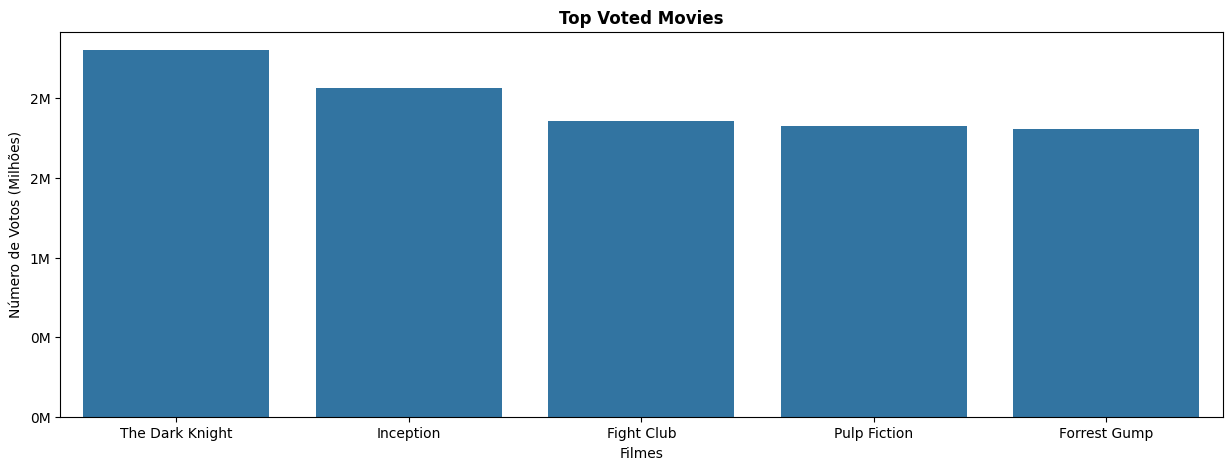

In [6]:
top_movies_most_voted = data_imdb.sort_values(['No_of_Votes'], ascending = False)

# Função para formatar números em milhões
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

fig, axs = plt.subplots(figsize=(15, 5))
g = sns.barplot(x=top_movies_most_voted['Series_Title'][:5], y=top_movies_most_voted['No_of_Votes'][:5], ax=axs)
g.set_title("Top Voted Movies", weight="bold")

# Definindo rótulos dos eixos
axs.set_xlabel('Filmes')
axs.set_ylabel('Número de Votos (Milhões)')

# Aplicando formatação de milhões no eixo y
formatter = FuncFormatter(millions_formatter)
axs.yaxis.set_major_formatter(formatter)

plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #FF0000; text-align: left; "><b>Observações:</b></h1>

* U (Universal): Indicado para todos os públicos.
* A (Adult): Recomendado para adultos ou adolescentes acompanhados.
* UA (Universal Adult): Recomendado para todas as idades, mas com a supervisão de adultos.
* R (Restricted): Restrito; pode ser inadequado para menores de 18 anos.
* PG-13 (Parental Guidance): Pode não ser adequado para menores de 13 anos; recomenda-se orientação dos pais.
* PG (Parental Guidance Suggested): Pode não ser adequado para crianças pequenas; recomenda-se orientação dos pais.
* Passed: Indica que o filme passou na revisão do código de produção ou de censura.


In [7]:
data_imdb['Certificate'].unique()

array(['A', 'UA', 'U', 'PG-13', 'R', nan, 'PG', 'G', 'Passed', 'TV-14',
       '16', 'TV-MA', 'Unrated', 'GP', 'Approved', 'TV-PG', 'U/A'],
      dtype=object)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* A análise gráfica dos dados sobre os filmes indica que há uma predominância de filmes classificados como adequados para todos os públicos.

* Filmes voltados para o público adulto também são bastante populares, representando o segundo maior segmento em termos de relevância.

* Nota-se ainda a presença de conteúdos que, apesar de serem recomendados para todos os públicos, requerem supervisão dos pais devido à inclusão de material sensível.

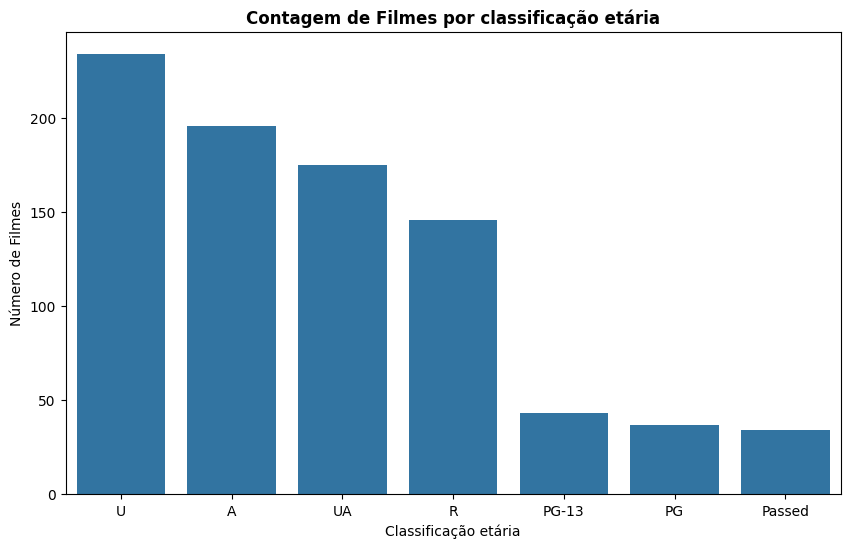

In [8]:
# Criação da figura e dos eixos
fig, axs = plt.subplots(figsize=(10, 6))

# Contagem de ocorrências de cada categoria de certificado
certificate_counts = data_imdb['Certificate'].value_counts()

# Criando o gráfico de barras
g = sns.barplot(x=certificate_counts.index[:7], y=certificate_counts.values[:7], ax=axs)

# Título do gráfico
g.set_title("Contagem de Filmes por classificação etária", weight="bold")

# Definindo rótulos dos eixos
axs.set_xlabel('Classificação etária')
axs.set_ylabel('Número de Filmes')

# Exibindo o gráfico
plt.show()

In [9]:
# Função para obter os top 5 filmes mais bem votados de uma categoria específica, ordenados por votos
def get_top_movies_by_certificate(data, certificate):
    top_movies = data[data['Certificate'] == certificate].nlargest(5, 'No_of_Votes')
    return top_movies

# Função para plotar os top 5 filmes mais bem votados por certificação
def plot_top_movies_by_certificate(data, certificate, millions=False):
    # Obtendo os top 5 filmes mais bem votados para a classificação especificada, ordenados por votos
    top_movies = get_top_movies_by_certificate(data, certificate)
    top_movies = top_movies.sort_values(by='No_of_Votes', ascending=False)  # Ordenando por número de votos
    
    # Configuração da figura e do subplot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotagem do gráfico de barras horizontal
    g = sns.barplot(x='No_of_Votes', y='Series_Title', data=top_movies, ax=ax)
    
    # Configuração do título do gráfico
    ax.set_title(f"Top 5 Filmes mais bem votados - Classificação: {certificate}")
    
    # Configuração dos rótulos dos eixos
    ax.set_xlabel('Número de Votos')
    ax.set_ylabel('Filme')
    
    # Exibindo os valores no eixo x como milhões, se especificado
    if millions:
        ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])
    
    # Exibindo o gráfico
    plt.tight_layout()
    plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* Observamos que, na classificação livre, o filme The Lord of the Rings foi o melhor avaliado, seguido pela sua continuação e por The Prestige. Isso demonstra a consistência dos dados em relação à popularidade e à qualidade percebida desses filmes.

C:\Users\allan\AppData\Local\Temp\ipykernel_15632\695597209.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])


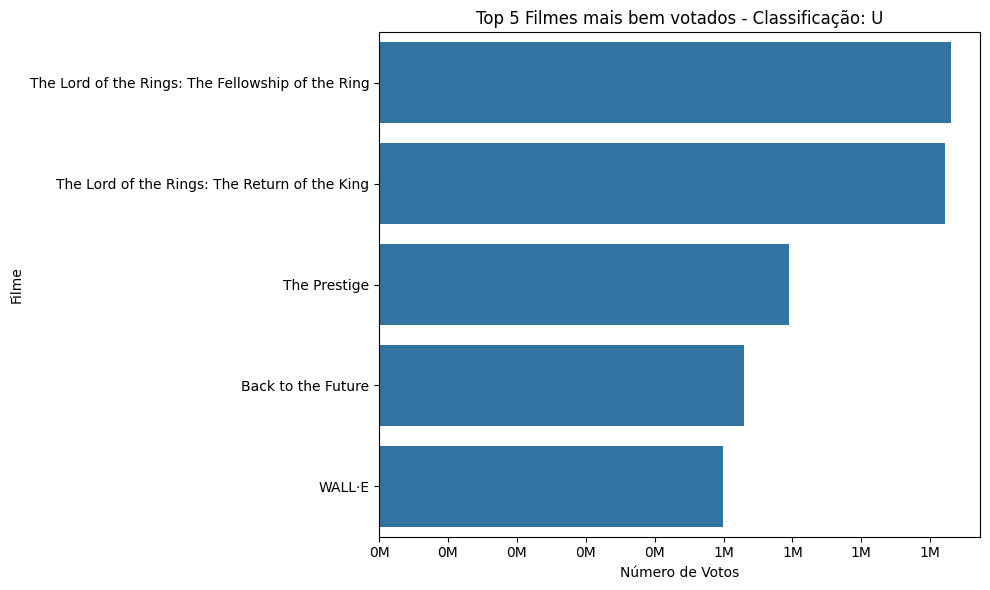

In [10]:
plot_top_movies_by_certificate(data_imdb, 'U', millions=True)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Ao analisar a classificação adulta podemos ver os filmes melhores avaliados, que são os filmes Fight Club com a melhor avaliação seguido de Pulp Fiction e The Matirx.

C:\Users\allan\AppData\Local\Temp\ipykernel_15632\695597209.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])


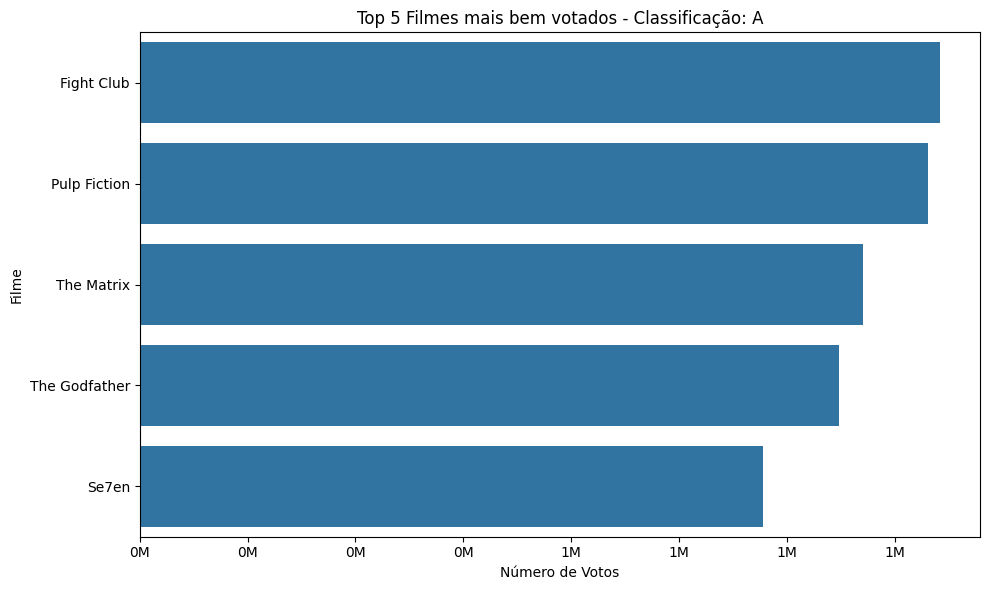

In [11]:
plot_top_movies_by_certificate(data_imdb, 'A', millions=True)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Ao analisar a classificação adulta podemos ver os filmes melhores avaliados, que são os filmes Fight Club com a melhor avaliação seguido de Pulp Fiction e The Matrix.

C:\Users\allan\AppData\Local\Temp\ipykernel_15632\695597209.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/1000000)}M' for x in ax.get_xticks()])


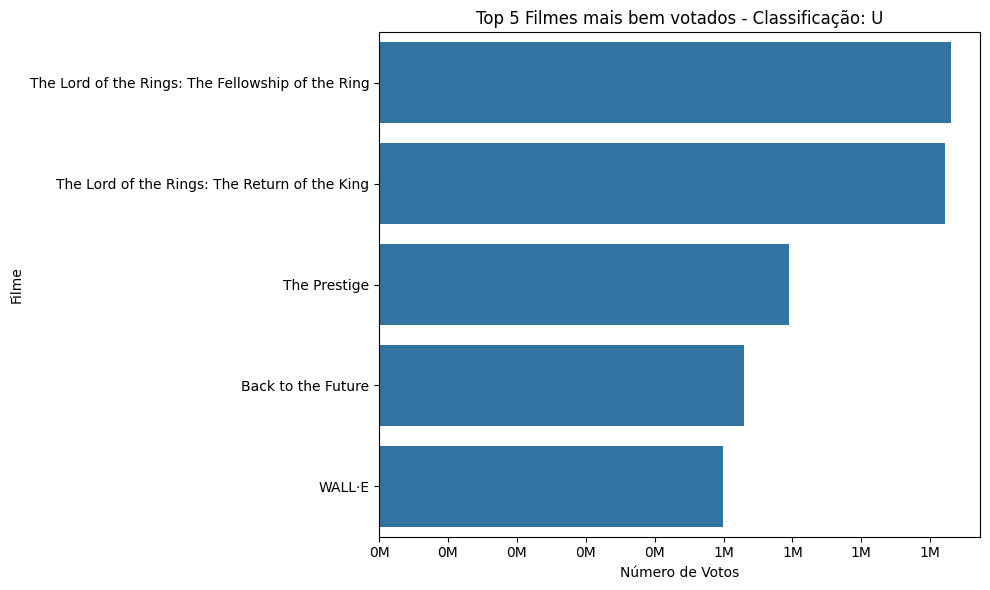

In [12]:
plot_top_movies_by_certificate(data_imdb, 'U', millions=True)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

<p>Nesta análise podemos observar o faturamento por diretor, ou seja, o montante de faturamento de todos os filmes de algum diretor. Observa-se que o diretor de destaque é o <a href="https://pt.wikipedia.org/wiki/Steven_Spielberg" style="color: #368f8b; text-decoration: none;">Steven Spielberg</a>, seguido de <a href="https://pt.wikipedia.org/wiki/Irm%C3%A3os_Russo" style="color: #368f8b; text-decoration: none;">Anthony Russo</a> e de <a href="https://pt.wikipedia.org/wiki/Christopher_Nolan" style="color: #368f8b; text-decoration: none;">Christopher Nolan</a>.</p>


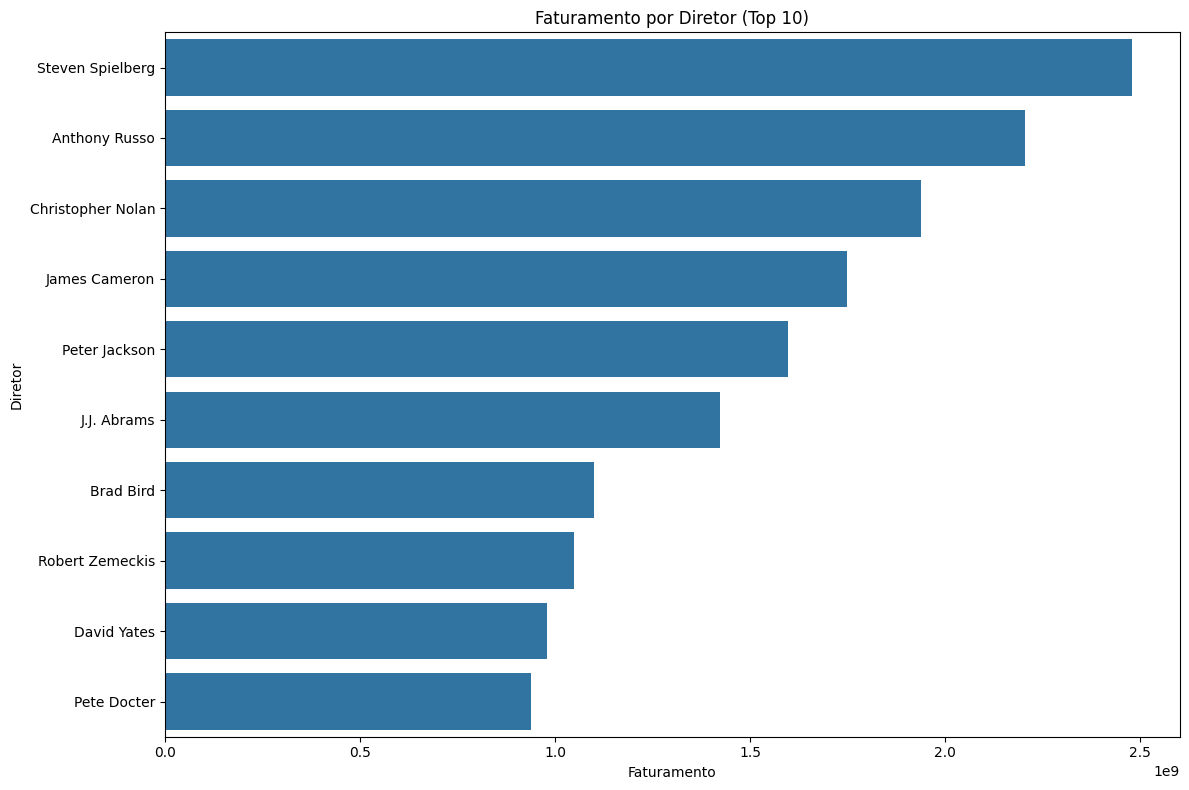

In [13]:
# Agrupando por diretor e somando o faturamento
director_gross = data_imdb.groupby('Director')['Gross'].sum().reset_index()

# Ordenando por faturamento decrescente
director_gross = director_gross.sort_values(by='Gross', ascending=False).head(10)

# Configurando a figura e os eixos
plt.figure(figsize=(12, 8))
sns.barplot(x='Gross', y='Director', data=director_gross)

# Configurando o título e os rótulos dos eixos
plt.title('Faturamento por Diretor (Top 10)')
plt.xlabel('Faturamento')
plt.ylabel('Diretor')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* <p>Nesta análise podemos observar o número de votos por diretor. Observa-se que o diretor que tem mais votos em seus filmes é o <a href="https://pt.wikipedia.org/wiki/Christopher_Nolan" style="color: #368f8b; text-decoration: none;">Christopher Nolan</a> seguido de Quentian Tarantino e <a href="https://pt.wikipedia.org/wiki/Steven_Spielberg" style="color: #368f8b; text-decoration: none;">Steven Spielberg</a>.</p>

* Observa-se que os dois mais bem faturados aparecem também na lista de mais bem votados, ou seja, os diretores que t~em seus filmes bem mais votados.


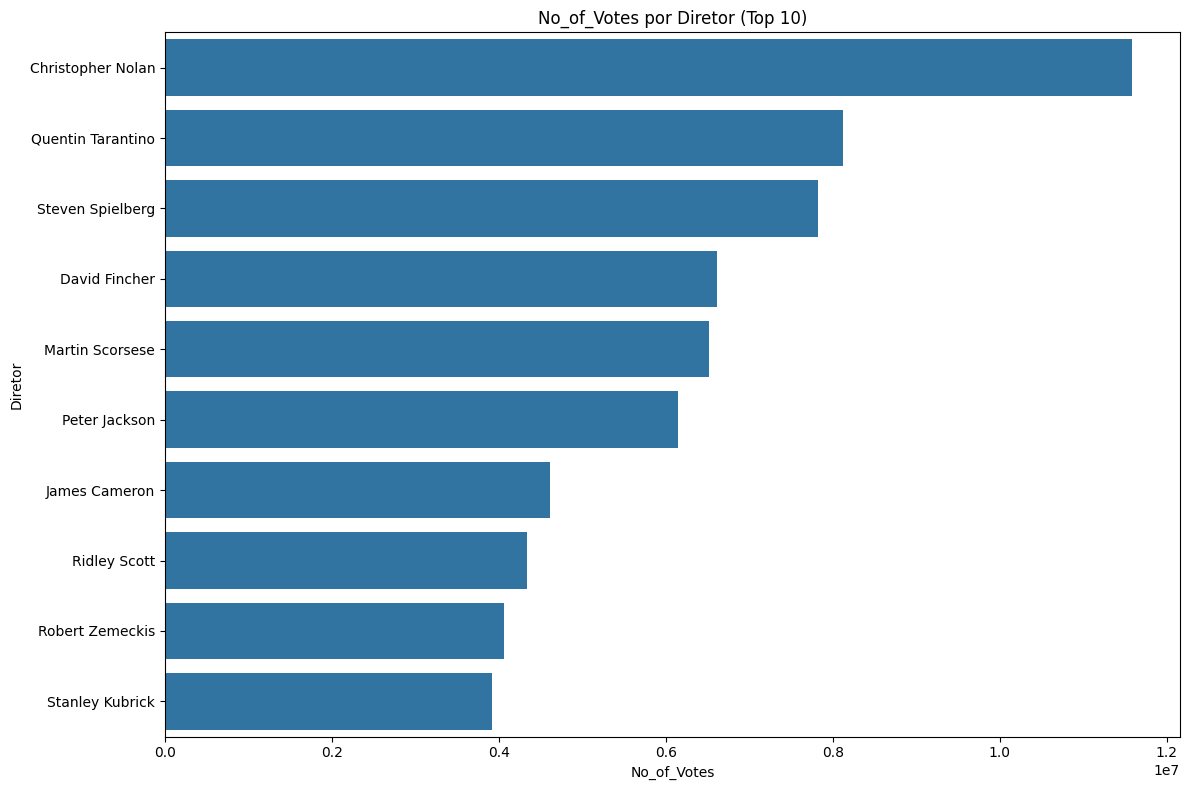

In [14]:
# Agrupando por diretor e somando o No_of_Votes
director_No_of_Votes = data_imdb.groupby('Director')['No_of_Votes'].sum().reset_index()

# Ordenando por faturamento decrescente
director_No_of_Votes = director_No_of_Votes.sort_values(by='No_of_Votes', ascending=False).head(10)

# Configurando a figura e os eixos
plt.figure(figsize=(12, 8))
sns.barplot(x='No_of_Votes', y='Director', data=director_No_of_Votes)

# Configurando o título e os rótulos dos eixos
plt.title('No_of_Votes por Diretor (Top 10)')
plt.xlabel('No_of_Votes')
plt.ylabel('Diretor')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* Percebe-se que o filme que obteve, de mandeira geral o maior faturamento em relação aos demais foi o filme Star Wars seguido pelos filmes do Avengers e suas sequências e filmes anteriores.


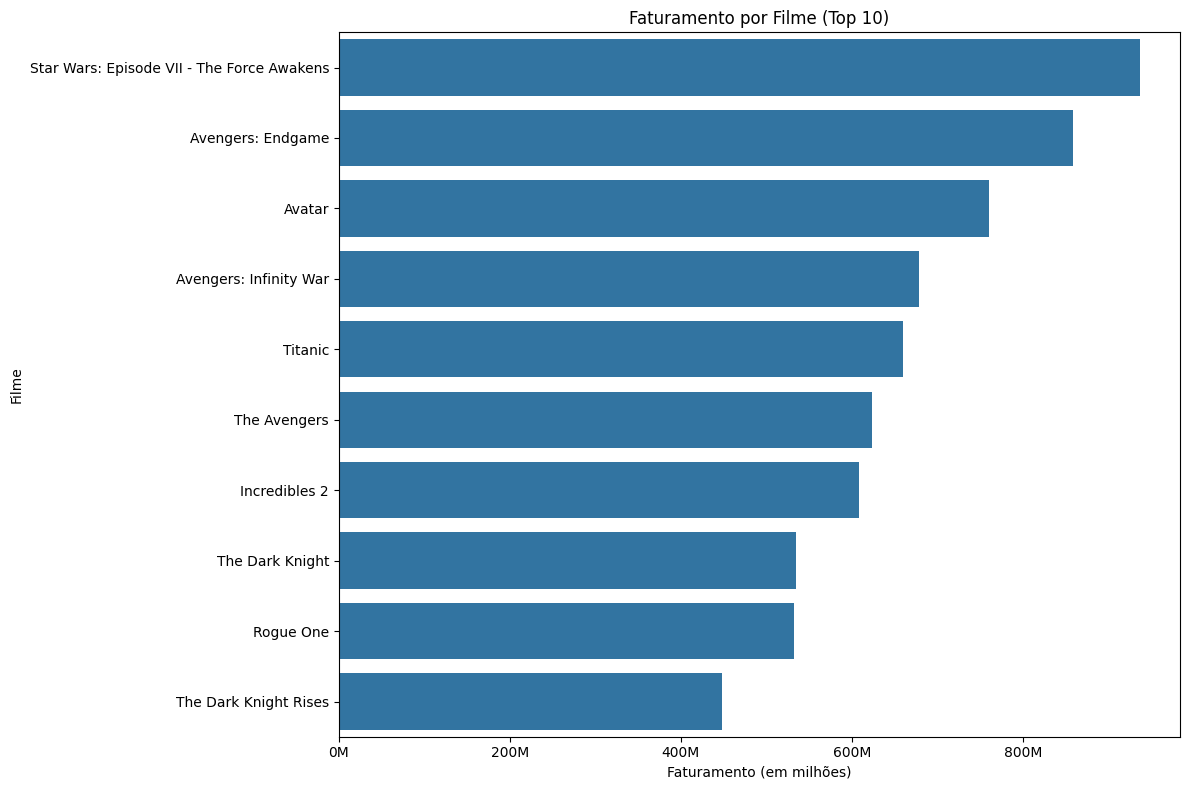

In [15]:
# Agrupando por filme e somando o faturamento
Series_Title_gross = data_imdb.groupby('Series_Title')['Gross'].sum().reset_index()

# Ordenando por faturamento decrescente e pegando os top 10
Series_Title_gross = Series_Title_gross.sort_values(by='Gross', ascending=False).head(10)

# Convertendo o faturamento para milhões
Series_Title_gross['Gross_Millions'] = Series_Title_gross['Gross'] / 1e6  # Convertendo para milhões

# Configurando a figura e os eixos
plt.figure(figsize=(12, 8))
sns.barplot(x='Gross_Millions', y='Series_Title', data=Series_Title_gross)

# Configurando o título e os rótulos dos eixos
plt.title('Faturamento por Filme (Top 10)')
plt.xlabel('Faturamento (em milhões)')
plt.ylabel('Filme')

# Formatando os rótulos do eixo x para milhões
formatter = FuncFormatter(lambda x, _: f'{x:.0f}M')
plt.gca().xaxis.set_major_formatter(formatter)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [16]:
director_Series_Title = data_imdb.groupby('Director')['Series_Title'].apply(list).reset_index()
director_Series_Title = director_Series_Title.explode('Series_Title')
director_Series_Title[director_Series_Title['Director'] == 'Steven Spielberg']


,Director,Series_Title
470,Steven Spielberg,Schindler's List
470,Steven Spielberg,Saving Private Ryan
470,Steven Spielberg,Raiders of the Lost Ark
470,Steven Spielberg,Indiana Jones and the Last Crusade
470,Steven Spielberg,Catch Me If You Can
470,Steven Spielberg,Jurassic Park
470,Steven Spielberg,Jaws
470,Steven Spielberg,The Color Purple
470,Steven Spielberg,E.T. the Extra-Terrestrial
470,Steven Spielberg,Empire of the Sun


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Insights:</b></h1>

* Pela matriz de correlação podemos observar que a medida que cresce o número de votos a faturamento do filme cresce, ou seja, a quantidade de votos e/ou avaliações está diretamente ligado ao crescimento do faturamento;
* Observa-se também que a medida que anota do IMDB cresce aquantidade de votos também cresce implicando que o faturamento irá crescer também.



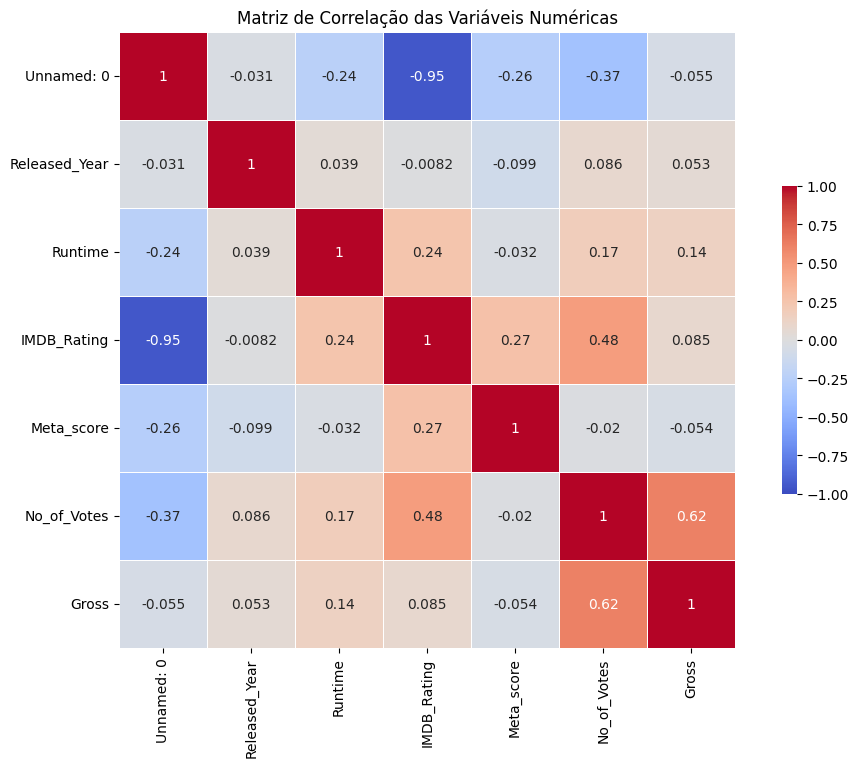

In [17]:
# Selecionando apenas as variáveis numéricas
numeric_columns = data_imdb.select_dtypes(include=['int64', 'float64'])

# Calculando a matriz de correlação
correlation_matrix = numeric_columns.corr()

# Configurando o tamanho da figura
plt.figure(figsize=(12, 8))

# Plotando a matriz de correlação usando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adicionando título
plt.title('Matriz de Correlação das Variáveis Numéricas')

# Exibindo o gráfico
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual filme você recomendaria para uma pessoa que você não conhece?</b></h1>

* As palavras "life", "one", "find", "love" aparecem bastante.



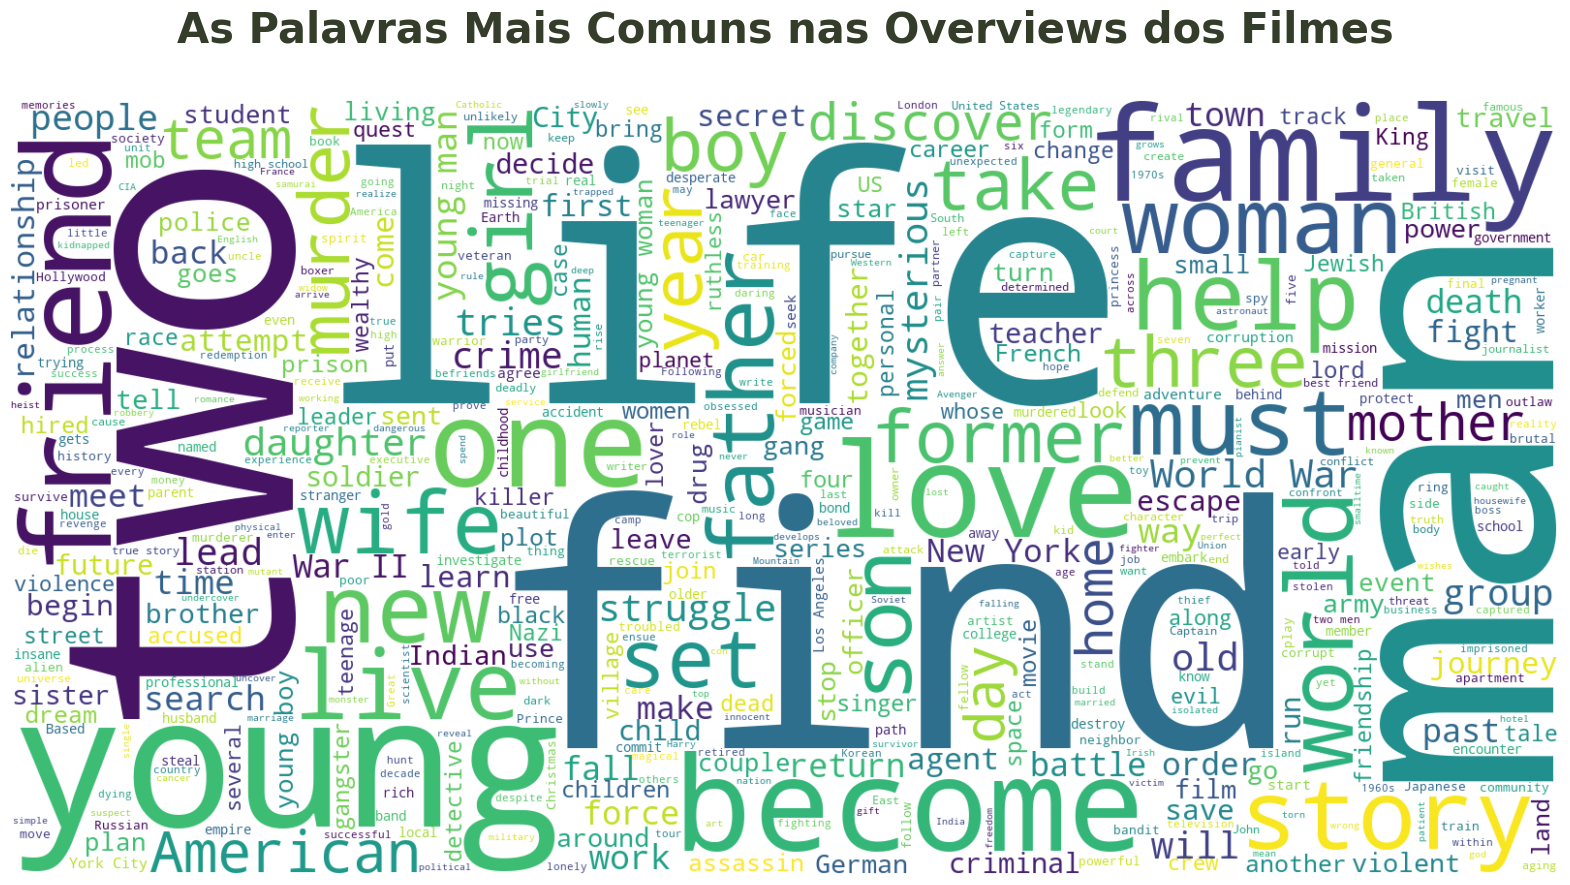

In [18]:
from wordcloud import WordCloud
import string

# Concatenando todas as overviews em uma única string
text = ' '.join(data_imdb['Overview'].fillna('').apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))))

# Criando a nuvem de palavras
plt.figure(figsize=(20, 20))
plt.title('As Palavras Mais Comuns nas Overviews dos Filmes\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600, background_color="white").generate(text)

# Exibindo a nuvem de palavras
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Removendo os eixos
plt.show()

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">PERGUNTAS EDA</p>


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual filme você recomendaria para uma pessoa que você não conhece?</b></h1>

* Recomendaria aquele filme com melhor avaliação, ou seja, recomendaria o filme The Dark Knight 

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 
</b></h1>

* Principalmente a quantidade de votos do filme, mas também o diretor que está dirigindo o filme têm grande influência. 

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

</b></h1>

* A "Overview" oferece uma visão geral do tema principal do filme. Isso pode ajudar a identificar se é um drama, ação, comédia, suspense, entre outros;
* Algumas sinopses podem indicar claramente para qual público o filme é direcionado. Por exemplo, se a sinopse descreve temas infantis, familiares, ou se aborda questões mais maduras e complexas;
* É possível utilizando métodos especificos determinar o gênero do filme.



#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">PRÉ-PROCESSAMENTO</p>


Nesta seção iremos fazer a abordagem de imputamento dos valores faltantes do nosso conjunto de dados e fazer as devidas normalizações do nosso conjunto. Há muitas vantagens em utilizar a normalização dos dados, tais como Melhora o desempenho dos modelos, evita viés em variáveis com diferentes escalas, Melhora a estabilidade numérica e entre outras vantagens.

* Para as variáveis qualitativas, podemos usar o OrdinalEncoder para codificar variáveis categóricas como números inteiros.

* Para as variáveis numéricas vamos aplicar o StandardScaler.

In [19]:
# Configurando o pré-processamento
numeric_features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross']
categorical_features = ['Certificate', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputação pela mediana
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputação pela moda
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Criando o pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Released_Year', 'Runtime',
                                                   'Meta_score', 'No_of_Votes',
                                                   'Gross']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Certificate', 'Director',
                                                   'Star1', 'Star2', 'Star3',
                                                   'Star4'])]))])

In [20]:
(data_imdb == 0).sum()


Unnamed: 0         0
Series_Title       0
Released_Year      1
Certificate        0
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score         0
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [21]:
data_imdb.isna().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross              0
dtype: int64

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #0000CD; text-align: left;"><b>Informações:</b></h1>

* Os valores faltantes de Meta_score, Gross e Released_Year serão imputados via mediana;

* Os valores faltantes de Certificate serão imputados via o valor que mais foi observado no conjunto de dados, ou seja, pelo "U". 

Antes de aplicar o nosso pipiline de pré-processamento precisamos dividir o nosso conjunto de dados como treino e teste, mas antes identificar as colunas que vamos usar na nossa modelagem e que são identificadas no código como "features" e o nosso alvo da previsão como "target".

In [22]:
features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross','Certificate', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']
target = 'IMDB_Rating'

X = data_imdb[features]
y = data_imdb[target]

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Pronto, os valores faltantes foram imputados e os dados foram normalizados!

In [23]:
# Aplicando o pipeline aos dados de treino e teste
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">MODELOS DE PREVISÃO DA NOTA IMDB</p>


Nesta etapa já estamos com o nosso conjunto de dados pré-processado e dividio na parte de treino e na parte de teste, bastando aplicar nos modelos.

A nota do IMBD é uma variável contínua, então para a sua previsão poderiamos usar métodos de regressão para determina-lo, pois não entra do caso de classificação.

Nosso problema para esse caso é de regressão: Determinar a note IMDB para os filmes.

Para os modelos de previsão usaremos o GridSearchCV



In [31]:
# Definir modelos para otimização
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}


In [46]:
# Definir os parâmetros a serem testados para cada modelo no Grid Search
param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
    'Lasso': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0],
    },
    'ElasticNet': {
        'alpha': [0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.5, 0.9],
    },
    'SVR': {
        'C': [0.1, 1.0, 10.0],
        'gamma': [0.1, 1.0],
        'epsilon': [0.01, 0.1, 1.0]
    },
    'Random Forest': {
        'n_estimators': [100, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 500],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 500],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0.1, 0.5],
        'reg_alpha': [1e-5, 0.1],
        'reg_lambda': [1e-5, 0.1]
    }
}

In [47]:
# Armazenar melhores modelos treinados
trained_models = {}

# Executar o Grid Search para cada modelo
for model_name, model in models.items():
    print(f"Otimizando hiperparâmetros para {model_name}...")
    
    # Definir o objeto GridSearchCV com o modelo correspondente
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='neg_mean_squared_error',  # Métrica a ser otimizada
        cv=5,  # Número de folds para validação cruzada
        n_jobs=-1  # Utilizar todos os núcleos do processador
    )

    # Realizar a otimização dos hiperparâmetros
    grid_search.fit(X_train_preprocessed, y_train)

    # Melhor modelo encontrado
    best_model = grid_search.best_estimator_
    trained_models[model_name] = best_model

    # Melhores hiperparâmetros encontrados
    print(f"Melhores hiperparâmetros encontrados para {model_name}:")
    print(grid_search.best_params_)

    # Avaliar o modelo com os melhores hiperparâmetros no conjunto de teste
    y_pred = best_model.predict(X_test_preprocessed)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error no conjunto de teste para {model_name}: {mse}\n")

Otimizando hiperparâmetros para Linear Regression...
Melhores hiperparâmetros encontrados para Linear Regression:
{'fit_intercept': True}
Mean Squared Error no conjunto de teste para Linear Regression: 0.05025305835097149

Otimizando hiperparâmetros para Lasso...
Melhores hiperparâmetros encontrados para Lasso:
{'alpha': 0.1}
Mean Squared Error no conjunto de teste para Lasso: 0.061247546075306115

Otimizando hiperparâmetros para Ridge...
Melhores hiperparâmetros encontrados para Ridge:
{'alpha': 10.0}
Mean Squared Error no conjunto de teste para Ridge: 0.0501603765914299

Otimizando hiperparâmetros para ElasticNet...
Melhores hiperparâmetros encontrados para ElasticNet:
{'alpha': 0.1, 'l1_ratio': 0.1}
Mean Squared Error no conjunto de teste para ElasticNet: 0.05109653508273484

Otimizando hiperparâmetros para SVR...
Melhores hiperparâmetros encontrados para SVR:
{'C': 1.0, 'epsilon': 0.01, 'gamma': 1.0}
Mean Squared Error no conjunto de teste para SVR: 0.06595841290055417

Otimizando 

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #0000CD; text-align: left;"><b>Nota:</b></h1>

* Podemos observar, dentre todos os modelos treinados, o que se saiu melhor na etapa de medida de desempenho foi o XGBRegressor. Os melhores parâmeros encontrados para esse modelo foi o {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">PERGUNTAS MODELOS DE PREVISÃO DA NOTA IMDB</p>


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Quais variáveis e/ou suas transformações você utilizou e por quê?</b></h1>

* Variáveis usadas: Released_Year, Runtime, Meta_score, No_of_Votes, Gross, Certificate, Director, Star1, Star2, Star3, Star4
* A motivação veio a partir da análise descritiva dos dados e pela importância dessas variáveis com as suas informações valiosas.


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual tipo de problema estamos resolvendo (regressão, classificação)?</b></h1>

* A nota do IMBD é uma variável contínua, então para a sua previsão poderiamos usar métodos de regressão para determina-lo, pois não entra do caso de classificação.

* Nosso problema para esse caso é de regressão: Determinar a note IMDB para os filmes.


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual modelo melhor se aproxima dos dados e quais seus prós e contras?</b></h1>

* O modelo que obteve uma melhor perfomace foi o XGBRegressor muito utilizado em competições e projetos;

* Prós do XGBRegressor: Alta Performance, Regularização Integrada, Flexibilidade e Larga Aceitação na Comunidade;

* Contras do XGBRegressor: Afinamento de Hiperparâmetros e Sensível a Overfitting.


<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left;"><b>Qual medida de performance do modelo foi escolhida e por quê?
</b></h1>

* Foi utilizado a medida Mean Squared Error, pois é  uma métrica amplamente utilizada na avaliação de modelos de regressão.

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">PREVISÕES</p>


In [55]:
# Dados de entrada para previsão
new_data = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': 142,
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': 28341469
}

# Criando um DataFrame com os dados de entrada
input_df = pd.DataFrame([new_data])
input_df = pipeline.transform(input_df[features])

In [56]:
# Iterando pelos pares chave-valor do dicionário
for nome, modelo in trained_models.items():
    print(f'Previsao com: {nome}, Valor: {modelo.predict(input_df)}')

Previsao com: Linear Regression, Valor: [9.17401886]
Previsao com: Lasso, Valor: [8.20203303]
Previsao com: Ridge, Valor: [9.14295213]
Previsao com: ElasticNet, Valor: [8.85429147]
Previsao com: SVR, Valor: [7.95173169]
Previsao com: Random Forest, Valor: [8.82981746]
Previsao com: Gradient Boosting, Valor: [8.86233342]
Previsao com: XGBoost, Valor: [8.8607235]


Relembrando que o modelo que teve o melhor desempenho foi o XGBBoost.

#
<style>
    .custom-bg {
        background-color: #7d1a9b;
        font-family: Trebuchet MS;
        font-weight: bold;
        color: #eff7f6;
        font-size: 40px;
        text-align: center;
        border-radius: 100px;
        padding: 20px;
        display: block;
        width: 100%;
        margin: 0;
    }
</style>

<p class="custom-bg">SALVANDO OS MODELOS</p>


In [65]:
# Iterando pelos pares chave-valor do dicionário
for nome, modelo in trained_models.items():
    joblib.dump(modelo, f'modelos/modelo_{nome}.pkl')